In [50]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import shutil

### Reorganize data 

wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```


Only run below code if cifar hasnt been organized 


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
folders = ["data/cifar/train/", "data/cifar/test/"]

#for each label save all files with that label name to a new subfolder
#prints number of files in each new subfolder as a sanity check 
#5000 for each in training, 1000 for testing 
for folder in folders:    
    for label in labels:
        print (label)
        os.makedirs(folder+label)
        files = !ls {folder}
        file_counter = 0
        for filename in files:
            if label in filename and ".png" in filename:
                file_counter += 1
                src = folder+filename
                dst = folder+label+"/"+filename
                shutil.move(src, dst)
        print(file_counter)

### Load and Setup Data

In [51]:
from fastai.conv_learner import *

PATH = "data/cifar/"
os.makedirs(PATH, exist_ok =True) #makes dirs if they dont 

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

labels.txt
models
test
tmp
train
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [52]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

#pass in mean and std of each channel for both training and testing 
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), 
         np.array([ 0.24703,  0.24349,  0.26159]))

def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [53]:
data = get_data(64,5)

In [54]:
x,y = next(iter(data.trn_dl))

In [55]:
#5 samples, 3 channels, 64 by 64
x.shape

torch.Size([5, 3, 64, 64])

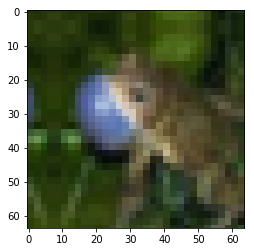

In [56]:
plt.imshow(data.trn_ds.denorm(x)[0])

### FC Net

In [57]:
bs = 256
lr = 1e-2
data = get_data(32, 256)

In [58]:
class FCNet (nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
    def forward(self, x):
        #transform x to be correct size
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [59]:
#create learn object from a custom pytorch model and model data object 
learn = ConvLearner.from_model_data(FCNet([32*32*3,40,10]), data)

In [60]:
learn

FCNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [61]:
[o.numel() for o in learn.model.parameters()]

[122880, 40, 400, 10]

In [62]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [63]:
learn.lr_find()
learn.sched.plot()

 16%|█▋        | 32/196 [01:32<07:52,  2.88s/it, loss=2.32] 

KeyboardInterrupt: 

In [ ]:
%time learn.fit(lr, 2)
%time learn.fit(lr, 2, cycle_len=1)

### ConvNet

In [ ]:
class ConvNet (nn.Module):
    def __init__ (self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i+1],kernel_size=3, stride=2) 
            for i in range(len(layers)-1)])
        self. pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward (self, x):
        for l in self.layers:
            x = F.relu(l(x)) #computers the conv for loop
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([3,20,40,80], 10), data)
learn.summary()

In [ ]:
learn.lr_find(end_lr=100)
learn.sched.plot()

In [ ]:
%time learn.fit(1e-1, 2)
%time learn.fit(1e-1, 4, cycle_len=1)

### Refactored Conv Net (add in Conv2D layer class)

In [ ]:
#layer and net definition are same in pytorch
class ConvLayer (nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return F.relu(self.conv(x))

In [ ]:
class ConvNet2 (nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            ConvLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        for l in self.layers: x = l(x) #relu taken care of by layer class above
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1) 
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)
learn.summary()

In [ ]:
%time learn.fit(1e-1, 2)
%time learn.fit(1e-1, 2, cycle_len=1)

### Batch Norm 
Adding in batch norm stabilizes convergence and weight matrices by keeping them at reasonable scale through normalizing on each layer 


In [128]:
class BNLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=kernel_size, stride=stride, 
                             bias=False,padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self,x):
        x = F.relu(self.conv(x))
        #x_chan repersents the channel values for each sample
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1) 
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds =  x_chan.std(1)[:,None,None]
        return (x-self.means)/ self.stds * self.m + self.a

In [129]:
a = torch.randn(3,20,20)
a_chan = a.transpose(0,1).contiguous().view(a.size(1),-1)
print(a_chan)

mean = a_chan.mean(1)[:,None,None]
mean.size()


 0.6555 -1.1018 -0.7108  ...   0.9842  0.6417 -1.0652
 2.0097  1.4551 -0.3500  ...  -0.1573 -0.0112  0.4167
 0.2730  0.5392 -0.8584  ...   0.0482 -0.4714  1.2618
          ...             ⋱             ...          
-1.1181  1.1319  2.3021  ...   0.1011 -0.1044 -0.5180
 0.3100 -1.3992 -0.3047  ...   1.0966 -0.5785  0.0566
 0.9891  0.2972  0.1819  ...  -0.0825 -1.5031 -0.0631
[torch.FloatTensor of size 20x60]



torch.Size([20, 1, 1])

In [130]:
class ConvBNNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BNLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        #first layer is conv with large filter to capture rich features 
        x = self.conv1(x)
        for l in self.layers:
            x = l(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)
        

In [131]:
learn = ConvLearner.from_model_data(ConvBNNet([10, 20, 40, 80, 160], 10), data)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BNLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BNLayer-5',
              OrderedDict([

In [98]:
%time learn.fit(3e-2, 2)


epoch      trn_loss   val_loss   accuracy                   
    0      1.161058   1.071944   0.621     
    1      1.095507   1.061649   0.6219                     
Wall time: 28.3 s


[array([1.06165]), 0.6219]

In [99]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.04591    0.951704   0.6654    
    1      0.997957   0.923001   0.6748                      
    2      0.95889    0.898968   0.6835                      
    3      0.922772   0.861733   0.6991                      
Wall time: 57.7 s


[array([0.86173]), 0.6991]

### Deep BatchNorm

We now add another stride 1 layer after each stride 2 layer, note that stride 2 layers halve the size 

In [126]:
class ConvBNNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BNLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BNLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        #first layer is conv with large filter to capture rich features 
        x = self.conv1(x)
        for l, l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)
        

In [127]:
learn = ConvLearner.from_model_data(ConvBNNet2([10, 20, 40, 80, 160], 10), data)
%time learn.fit(1e-2, 2)
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.517748   1.346363   0.512     
    1      1.285908   1.198571   0.5691                     
Wall time: 33.4 s


epoch      trn_loss   val_loss   accuracy                   
    0      1.105306   1.020558   0.6302    
    1      1.038023   0.987595   0.6551                     
Wall time: 32.8 s


[array([0.98759]), 0.6551]

### RNN

In [152]:
class ResnetLayer(BNLayer):
    def forward(self,x):
        return x + super().forward(x)  
    
class Resnet (nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([
            BNLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
    
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        return F.log_softmax(self.out(x), dim=-1)

In [153]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)
wd=1e-5
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.632872   1.653201   0.4711    
    1      1.377909   1.245565   0.5487                     
Wall time: 39.5 s


[array([1.24556]), 0.5487]

In [154]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.172699   1.127429   0.5946    
    1      1.124879   1.063845   0.6252                     
    2      0.984406   0.949687   0.668                       
    3      1.033848   0.988644   0.6471                     
    4      0.912622   0.959641   0.6712                      
    5      0.823088   0.838152   0.7074                      
    6      0.771403   0.806605   0.7183                      
Wall time: 2min 18s


epoch      trn_loss   val_loss   accuracy                    
    0      0.885609   0.911275   0.6819    
    1      0.785193   0.838535   0.7125                      
    2      0.700643   0.733968   0.7387                      
    3      0.667494   0.725259   0.7405                      
    4      0.775057   0.765866   0.7364                      
    5      0.690376   0.726724   0.7475                      
    6      0.609008   0.66837    0.7645                      
    7      0.577054   0.665488   0.7691                      
    8      0.680076   0.734451   0.7457                      
    9      0.620363   0.679057   0.7674                      
    10     0.553914   0.626078   0.7818                      
    11     0.513744   0.631943   0.7812                      
    12     0.627038   0.671287   0.7671                      
    13     0.560127   0.617067   0.788                       
    14     0.488473   0.597277   0.7923                      
    15     0.454483   0.60

[array([0.52971]), 0.8272]

### Resnet 2

Increased feature sizes and added dropout

In [157]:
class Resnet2 (nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BNLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([
            BNLayer(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l, l2, l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x,1)
        x = x.view(x.size(0),-1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)
wd=1e-6
%time learn.fit(1e-2, 2, wds=wd)
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
metrics.log_loss(y,preds), accuracy(preds,y)


epoch      trn_loss   val_loss   accuracy                   
    0      1.655834   1.518325   0.4389    
    1      1.462612   1.312996   0.5295                     
Wall time: 44.8 s


epoch      trn_loss   val_loss   accuracy                   
    0      1.231459   1.131251   0.595     
    1      1.18313    1.075431   0.6152                     
    2      1.054282   1.028196   0.6275                     
    3      1.124273   1.102465   0.609                      
    4      1.005835   0.939598   0.6679                     
    5      0.899107   0.883041   0.6857                      
    6      0.851606   0.861324   0.6934                      
Wall time: 2min 35s


epoch      trn_loss   val_loss   accuracy                    
    0      0.974136   0.901752   0.6831    
    1      0.879838   0.825353   0.7102                      
    2      0.78337    0.77476    0.7293                      
    3      0.73282    0.747417   0.7365                      
    4      0.850769   0.82712    0.7095                      
    5      0.765538   0.742317   0.741                       
    6      0.688831   0.698891   0.7583                      
    7      0.63725    0.672479   0.7649                      
    8      0.752892   0.726968   0.745                       
    9      0.681857   0.684996   0.7632                      
    10     0.603353   0.642885   0.7742                      
    11     0.553919   0.63652    0.7761                      
    12     0.683906   0.718445   0.7523                      
    13     0.618704   0.624284   0.7833                      
    14     0.545724   0.604186   0.7912                      
    15     0.521278   0.59